<a href="https://colab.research.google.com/github/KaufmanDmitriy/YandexPracticum/blob/main/final%20project/final_project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предсказание температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нужно построить модель, которая предскажет температуру стали.

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Изучение данных

In [3]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from catboost import CatBoostRegressor
from google.colab import drive
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [5]:
RANDOM_STATE = 80523
TEST_SIZE = 0.25

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


Считывание данных

In [7]:
path_to_data = '/content/drive/MyDrive/Colab Notebooks/final_project_data/'
data_arc = pd.read_csv(path_to_data + 'data_arc_new.csv')
data_bulk = pd.read_csv(path_to_data + 'data_bulk_new.csv')
data_bulk_time = pd.read_csv(path_to_data + 'data_bulk_time_new.csv')
data_gas = pd.read_csv(path_to_data + 'data_gas_new.csv')
data_temp = pd.read_csv(path_to_data + 'data_temp_new.csv')
data_wire = pd.read_csv(path_to_data + 'data_wire_new.csv')
data_wire_time = pd.read_csv(path_to_data + 'data_wire_time_new.csv')

Рассмотрим каждую таблицу.

In [8]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [9]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Пропусков в данных нет. Столбцы с временными значениями нужно привести к типу datetime.

In [10]:
data_arc.duplicated().sum()

0

Явных дубликатов нет.

In [11]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


В реактивной мощности минимальное значение -715 является аномальным. Посмотрим, есть ли ещё значения меньше 0 в столбце.

In [12]:
data_arc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Только одно такое значение, его нужно будет удалить.

<Axes: xlabel='Активная мощность', ylabel='Count'>

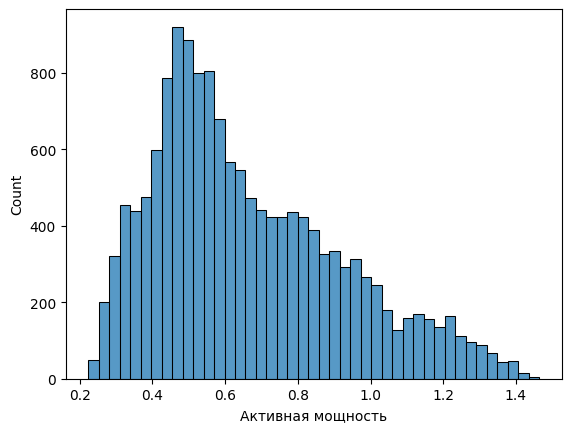

In [13]:
sns.histplot(x=data_arc['Активная мощность'])

<Axes: xlabel='Реактивная мощность', ylabel='Count'>

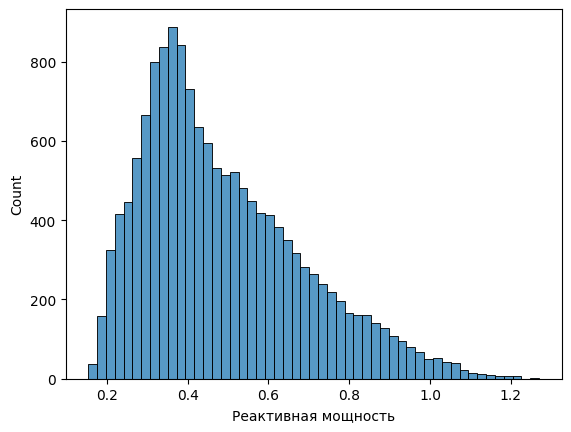

In [14]:
sns.histplot(x=data_arc.loc[data_arc['Реактивная мощность'] >= 0, 'Реактивная мощность'])

Мощность имеет нормальное распределение с длинным правым хвостом.

Рассмотрим данные о подаче материалов.

In [15]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [16]:
data_bulk.head(15)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


В таблице 15 различных материалов. Много пропущенных значений, скорее всего это значит, что данный материал не подавался. Эти пропуски нужно заполнить нулями.

In [17]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Можно заметить, что материал под номером 8 использовался лишь один раз.

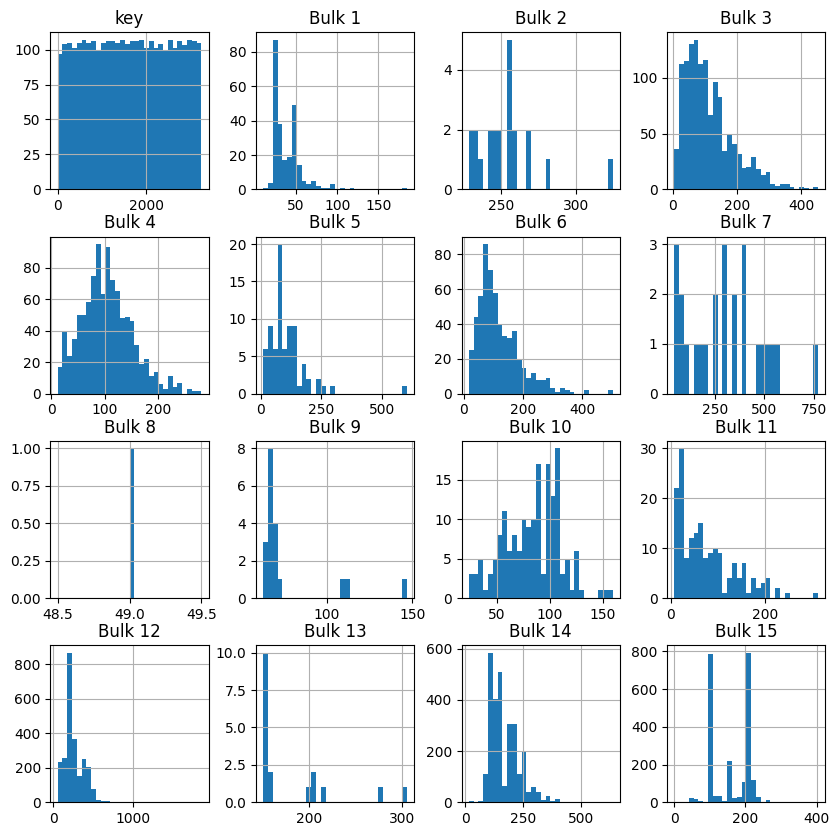

In [18]:
data_bulk.hist(bins=30, figsize=(10, 10));

Для многих материалов данных маловато. Выброс можно увидеть на графике материала номер 12.

In [19]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


Приведено время начала подачи материала. Материалы, которые не были использованы, отмечены пропуском.

In [20]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [21]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Здесь похоже приведён объём газа, который использовали на каждую партию. Пропусков нет.

<Axes: xlabel='Газ 1', ylabel='Count'>

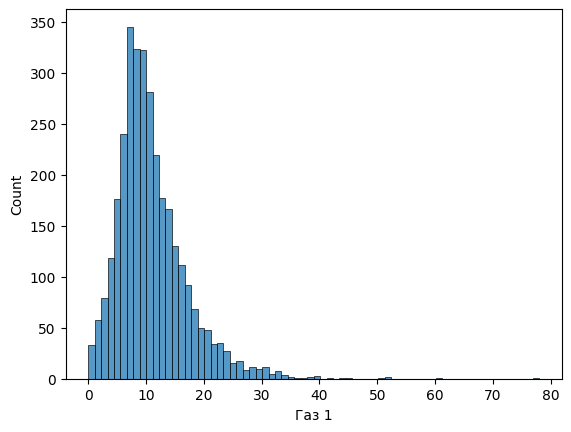

In [22]:
sns.histplot(x=data_gas['Газ 1'], bins=70)

<Axes: xlabel='Газ 1'>

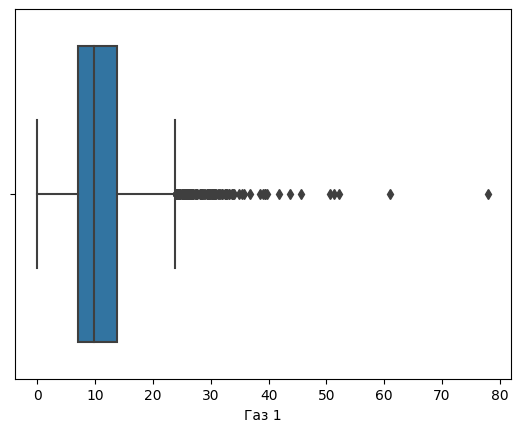

In [23]:
sns.boxplot(x=data_gas['Газ 1'])

Есть выбросы.

In [24]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [25]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [26]:
data_temp.isna().sum()

key                0
Время замера       0
Температура     3427
dtype: int64

В данных 3427 пропусков.

<Axes: xlabel='Температура', ylabel='Count'>

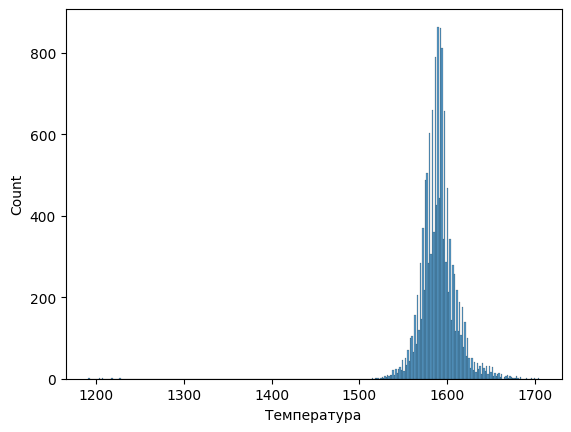

In [27]:
sns.histplot(x=data_temp['Температура'])

Данные имеют нормальное распределение. Есть выбросы - значения меньше 1500.

In [28]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


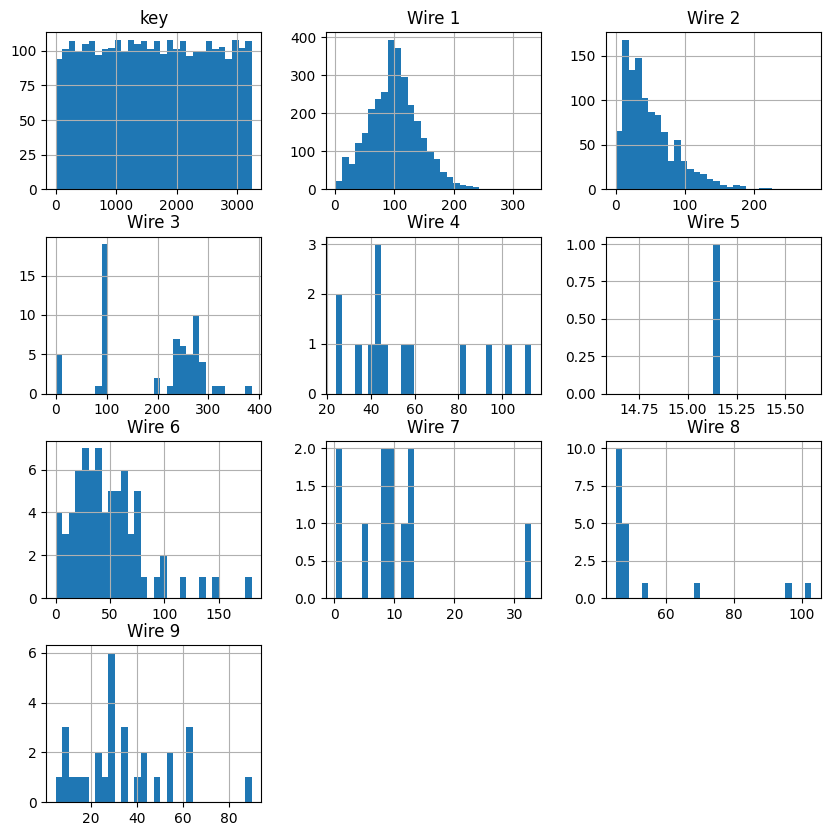

In [30]:
data_wire.hist(figsize=(10, 10), bins=30);

Здесь сложно сделать какие-то выводы, так как для многих материалов мало данных. По графикам аномалий не видно.

In [31]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Здесь также отмечено время подачи материалов.

## План решения задачи
**1) Предобработка данных**
- привести названия столбцов в датафреймах к правильному виду 
- удалить данные с выбросами из `data_arc` и `data_temp`
- соединить таблицы в одну через inner join
- разделить выборку на обучающую и тестовую
- сделать новые фичи: время нагрева, полная мощность, начальная температура, количество итераций нагрева

**2) Обучение моделей и подбор гиперпараметров**
- из моделей взять линейную регрессию и градиентный бустинг (LightGBM и CatBoost)
- для подбора гиперпараметров  использовать grid_search
- в качестве метрики использовать MAE
- выбрать модель с лучшей метрикой

**3) Проверка модели**
- выбранную модель проверить на тестовой выборке
- метрика MAE должна быть меньше 6.8

## Вопросы
- При удалении выброса в data_arc нужно удалить все значения для этого ключа?
- Есть материалы, которые использовались один раз. Этот признак можно удалить?
- Почему нельзя в модели использовать данные из data_bulk_time и data_wire_time?

## Предобработка данных



Изменим названия столбцов.

In [32]:
data_arc.columns = ['key', 'heating_start', 'heating_finish', 'active_power', 'reactive_power']

data_bulk_columns = ['key']
data_bulk_columns.extend(['bulk_' + str(i) for i in range(1, 16)])
data_bulk.columns = data_bulk_columns
data_bulk_time.columns = data_bulk_columns

data_gas.columns = ['key', 'gas']
data_temp.columns = ['key','measured_at', 'temp']

data_wire_columns = ['key']
data_wire_columns.extend(['wire_' + str(i) for i in range(1, 10)])
data_wire.columns = data_wire_columns
data_wire_time.columns = data_wire_columns

Удалим выброс из data_arc

In [33]:
data_arc = data_arc[data_arc['key'] != 2116]

Удалим выбросы из data_temp

In [34]:
temp_count = data_temp.groupby('key').agg({'temp': 'count'})
anomaly_key = data_temp.loc[data_temp['temp'] < 1500, 'key']
keys_with_nans = data_temp.loc[data_temp['temp'].isna(), 'key']

In [35]:
data_temp = data_temp[~(data_temp['key'].isin(temp_count[temp_count['temp'] == 1].index)) & (data_temp['temp'] >= 1500) & ~(data_temp['key'].isin(keys_with_nans))]

In [36]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13920 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          13920 non-null  int64  
 1   measured_at  13920 non-null  object 
 2   temp         13920 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 435.0+ KB


Заполним пропуски в `data_bulk`, `data_wire` нулями

In [37]:
data_bulk = data_bulk.fillna(0)
data_wire  = data_wire .fillna(0)

Приведём временные данные к типу datetime

In [38]:
data_arc['heating_start'] = pd.to_datetime(data_arc['heating_start'], format='%Y-%m-%d %H:%M:%S')
data_arc['heating_finish'] = pd.to_datetime(data_arc['heating_finish'], format='%Y-%m-%d %H:%M:%S')
data_temp['measured_at'] = pd.to_datetime(data_temp['measured_at'], format='%Y-%m-%d %H:%M:%S')

Отберём из data_temp нужные данные

In [39]:
data_temp_group = data_temp.groupby('key').agg({'temp': ['first', 'last'], 'measured_at': ['first', 'last']})
data_temp_group.columns = ['temp_first', 'temp_last', 'measured_first', 'measured_last']
data_temp_group = data_temp_group.reset_index()
data_temp_group['heating_time'] = (data_temp_group['measured_last'] - data_temp_group['measured_first']).dt.seconds
data_temp_group = data_temp_group.drop(['measured_first', 'measured_last'], axis=1)
data_temp_group.head()

,key,temp_first,temp_last,heating_time
0,1,1571.0,1613.0,1714
1,2,1581.0,1602.0,1265
2,3,1596.0,1599.0,1753
3,4,1601.0,1625.0,1220
4,5,1576.0,1602.0,1536


Подготовим data_arc

In [40]:
data_arc.head()

,key,heating_start,heating_finish,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [41]:
data_arc['iteration_time'] = (data_arc['heating_finish'] - data_arc['heating_start']).dt.seconds
data_arc['full_power'] = (data_arc['active_power'] ** 2 + data_arc['reactive_power'] ** 2) ** 0.5

In [42]:
data_arc_group = data_arc.groupby('key').agg({'active_power': 'mean', 'reactive_power': 'mean', 'full_power': 'mean', 'heating_start': 'count', 'iteration_time': 'mean'})
data_arc_group = data_arc_group.reset_index()
data_arc_group = data_arc_group.rename(columns={'heating_start': 'iterations'})

In [43]:
data_arc_group.head()

,key,active_power,reactive_power,full_power,iterations,iteration_time
0,1,0.607346,0.428564,0.743747,5,219.60
1,2,0.534852,0.363339,0.647087,4,202.75
2,3,0.812728,0.587491,1.003845,5,131.00
3,4,0.676622,0.514248,0.850010,4,185.25
4,5,0.563238,0.421998,0.704245,4,217.25


Из data_bulk и data_wire удалим материал, который использовался только один раз

In [44]:
data_bulk = data_bulk.drop('bulk_8', axis=1)

In [45]:
data_wire = data_wire.drop('wire_5', axis=1)

Объединим таблицы

In [46]:
merged_data = (data_arc_group.merge(data_temp_group, on='key')
                            .merge(data_bulk, on='key')
                            .merge(data_gas, on='key')
                            .merge(data_wire, on='key'))
merged_data.head()

,key,active_power,reactive_power,full_power,iterations,iteration_time,temp_first,temp_last,heating_time,bulk_1,...,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,0.607346,0.428564,0.743747,5,219.60,1571.0,1613.0,1714,0.0,...,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.534852,0.363339,0.647087,4,202.75,1581.0,1602.0,1265,0.0,...,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.812728,0.587491,1.003845,5,131.00,1596.0,1599.0,1753,0.0,...,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.676622,0.514248,0.850010,4,185.25,1601.0,1625.0,1220,0.0,...,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.563238,0.421998,0.704245,4,217.25,1576.0,1602.0,1536,0.0,...,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2327
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             2328 non-null   int64  
 1   active_power    2328 non-null   float64
 2   reactive_power  2328 non-null   float64
 3   full_power      2328 non-null   float64
 4   iterations      2328 non-null   int64  
 5   iteration_time  2328 non-null   float64
 6   temp_first      2328 non-null   float64
 7   temp_last       2328 non-null   float64
 8   heating_time    2328 non-null   int64  
 9   bulk_1          2328 non-null   float64
 10  bulk_2          2328 non-null   float64
 11  bulk_3          2328 non-null   float64
 12  bulk_4          2328 non-null   float64
 13  bulk_5          2328 non-null   float64
 14  bulk_6          2328 non-null   float64
 15  bulk_7          2328 non-null   float64
 16  bulk_9          2328 non-null   float64
 17  bulk_10         2328 non-null   f

Для обучения удалим ключ из данных

In [48]:
final_data = merged_data.drop('key', axis=1)

In [49]:
X = final_data.drop('temp_last', axis=1)
y = final_data['temp_last']

Посмотрим на корреляцию признаков

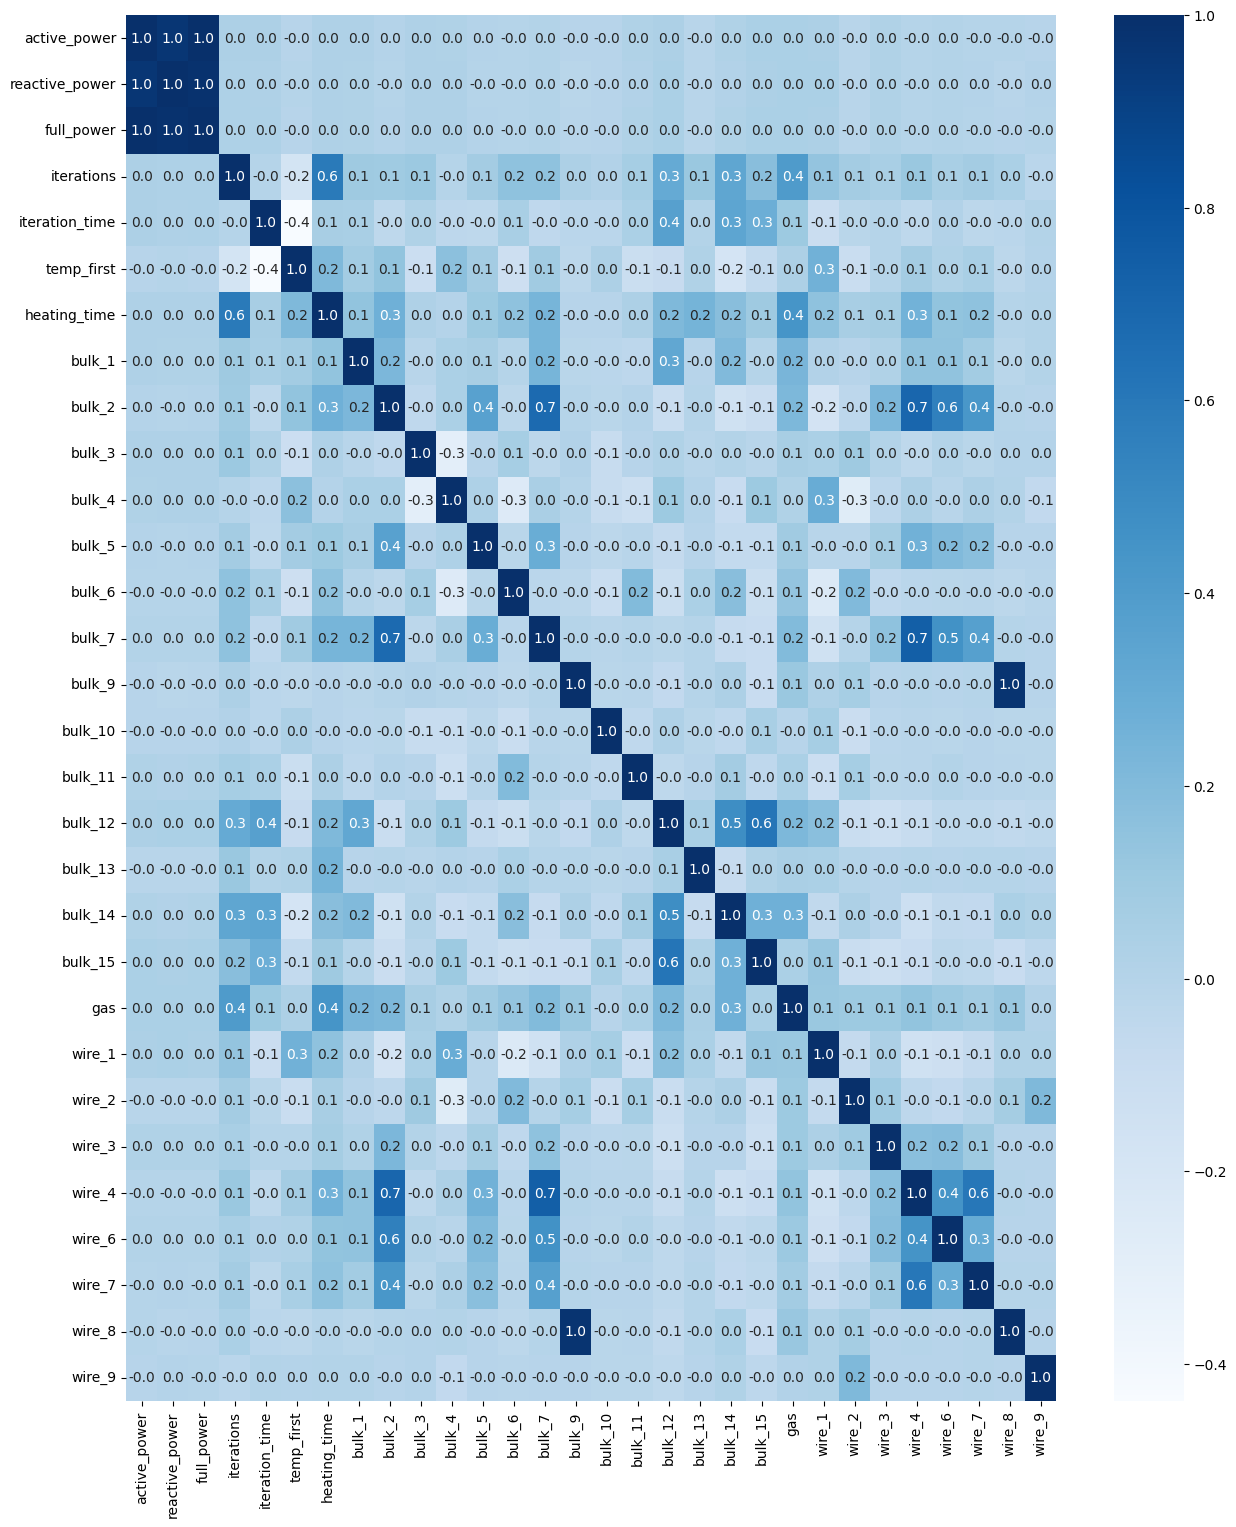

In [50]:
plt.figure(figsize=(15, 18))
sns.heatmap(X.corr(), cmap='Blues', annot=True, fmt='.1f');

Признаки active_power, reactive_power и full_power обладают полной корреляцией. Оставим только full_power.

In [51]:
X = X.drop(['active_power', 'reactive_power'], axis=1)

bulk_9 и wire_8 коллинеарны, удалим один из этих признаков.

In [52]:
X = X.drop('bulk_9', axis=1)

Разделим выбрку на обучающую и тестовую

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## Обучение модели

### Линейная регрессия

In [54]:
lin_reg = LinearRegression()

In [55]:
pipe = Pipeline([('scaler', StandardScaler()), ('linear', lin_reg)])

In [56]:
grid = GridSearchCV(pipe, {}, scoring='neg_mean_absolute_error')

In [57]:
%%time
grid.fit(X_train, y_train)

CPU times: user 80.1 ms, sys: 82.8 ms, total: 163 ms
Wall time: 127 ms


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('linear', LinearRegression())]),
             param_grid={}, scoring='neg_mean_absolute_error')

In [58]:
print(f'Значение MAE на кросс-валидации линейной регрессии: {abs(grid.best_score_):.3f}')

Значение MAE на кросс-валидации линейной регрессии: 6.304


### LightGBM

In [59]:
lgbm = LGBMRegressor(random_state=RANDOM_STATE)
param_grid_lgbm = {'max_depth': range(2, 7), 'learning_rate': [0.01, 0.05, 0.03, 0.1, 0.15],
                   'num_leaves': range(3, 10), 'n_estimators': [200, 500, 750, 1000]}
lgbm_grid = GridSearchCV(lgbm, param_grid_lgbm, scoring='neg_mean_absolute_error')

In [60]:
%%time
lgbm_grid.fit(X_train, y_train, eval_metric='mae')

CPU times: user 14min 45s, sys: 19.1 s, total: 15min 4s
Wall time: 8min 25s


GridSearchCV(estimator=LGBMRegressor(random_state=80523),
             param_grid={'learning_rate': [0.01, 0.05, 0.03, 0.1, 0.15],
                         'max_depth': range(2, 7),
                         'n_estimators': [200, 500, 750, 1000],
                         'num_leaves': range(3, 10)},
             scoring='neg_mean_absolute_error')

In [61]:
lgbm_grid.best_estimator_

LGBMRegressor(learning_rate=0.03, max_depth=3, n_estimators=1000, num_leaves=4,
              random_state=80523)

In [62]:
print(f'Значение MAE на кросс-валидации LGBM: {abs(lgbm_grid.best_score_):.3f}')

Значение MAE на кросс-валидации LGBM: 5.848


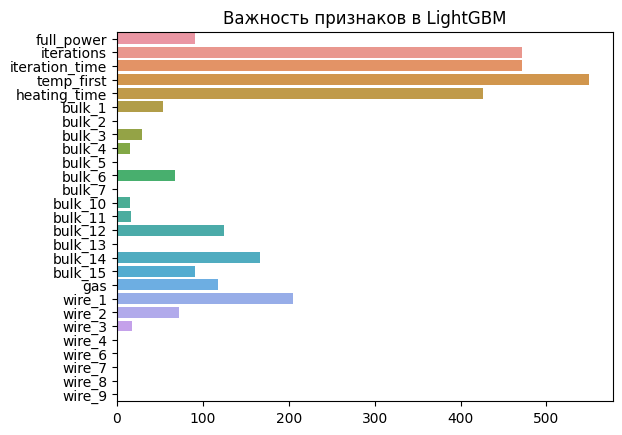

In [63]:
sns.barplot(y=X_train.columns, x=lgbm_grid.best_estimator_.feature_importances_)
plt.title('Важность признаков в LightGBM');

### CatBoost

In [64]:
cat_boost = CatBoostRegressor(eval_metric='MAE', verbose=False, random_state=RANDOM_STATE)
params = {'depth': range(2, 6), 'learning_rate': [0.1, 0.15, 0.05, 0.01], 'iterations': [200, 350, 500, 1000, 1500]}

In [65]:
cat_boost_grid = GridSearchCV(cat_boost, params, scoring='neg_mean_absolute_error')

In [66]:
%%time
cat_boost_grid.fit(X_train, y_train)

CPU times: user 8min 14s, sys: 26 s, total: 8min 40s
Wall time: 5min 5s


GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7fcd7efbe860>,
             param_grid={'depth': range(2, 6),
                         'iterations': [200, 350, 500, 1000, 1500],
                         'learning_rate': [0.1, 0.15, 0.05, 0.01]},
             scoring='neg_mean_absolute_error')

In [67]:
cat_boost_grid.best_estimator_.get_params()

{'iterations': 1000,
 'learning_rate': 0.05,
 'depth': 3,
 'loss_function': 'RMSE',
 'verbose': False,
 'eval_metric': 'MAE',
 'random_state': 80523}

In [68]:
print(f'Значение MAE на кросс-валидации CatBoost: {abs(cat_boost_grid.best_score_):.3f}')

Значение MAE на кросс-валидации CatBoost: 5.767


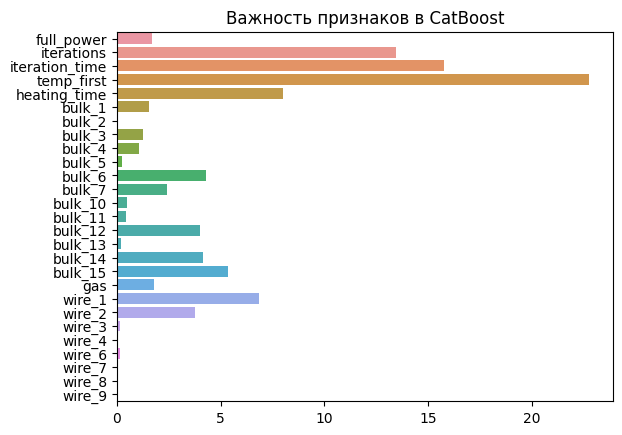

In [69]:
sns.barplot(y=X_train.columns, x=cat_boost_grid.best_estimator_.get_feature_importance())
plt.title('Важность признаков в CatBoost');

## Проверка модели

На кросс-валидации лучший показатель мерики у CatBoost. Возьмём эту модель, обучим на всей обучающей выборке и проверим результат на тестовой.

In [70]:
final_model = cat_boost_grid.best_estimator_

In [71]:
%%time
final_model.fit(X_train, y_train)

CPU times: user 1.42 s, sys: 64.9 ms, total: 1.49 s
Wall time: 812 ms


In [72]:
print(f'Значение MAE модели на тестовой выборке: {mean_absolute_error(y_test, final_model.predict(X_test)):.3f}')

Значение MAE модели на тестовой выборке: 6.226


Получили значение метрики MAE равное 6.226, что ниже требуемой отметки 6.8.

## Отчёт

### Описание задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нужно построить модель, которая по технологическим параметрам предскажет температуру стали.

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### Изучение данных

Были расммотрены все представленные данные. Обнаружены аномальные значения в таблицах `data_arc` и `data_temp`. В первом случае это значение мощности -700. Во втором - значения измеренной температуры < 1500 и пропущенные значения. Также в таблицах `data_wire` и `data_bulk` были материалы, которые использовались всего один раз. Эти проблемы были устранены на этапе предобработки данных.

### Предобработка данных

Были изменены названия колонок в таблицах на более подходящие. Были устранены описанные выше аномалии в данных. Также были удалены коллинеарные признаки. После этого данные были объединены в одну таблицу методом merge по значению key. В итоговую таблицу попали только те партии, которые встречаются во всех таблицах. Были добавлены новые фичи: время нагрева, полная мощность, начальная температура, количество итераций нагрева. В итоговой таблице осталось 2328 строк. 

После данные были разделены на обучающую и тестовую выборки. На тестовую выборку приходится 25% данных.

### Обучение модели

Для обучения были выбраны 3 модели: линейная регрессия и две реализации градиентного бустинга: LightGBM и CatBoost. Для обучению используем кросс-валидацию с 5 фолдами. Гиперпараметры подбираются поиском по сетке. Модель оценивается метрикой MAE. Для линейной регрессии данные предварительно масштабируются.

Результаты моделей:

Линейная регрессия - 6.304

LightGBM - 5.848

CatBoost - 5.767

В качестве итоговой модели выбран CatBoostRegressor с гиперпараметрами:

'iterations': 1000,
 'learning_rate': 0.05,
 'depth': 3,
 'loss_function': 'RMSE',
 'eval_metric': 'MAE'

 Метрика итоговой модели на тестовой выборке - 6.226